In [5]:
import cv2
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Function to extract Canny edges from images
def extract_canny_edges(image_folder, common_size):
    edge_features = []
    for filename in sorted(os.listdir(image_folder)):
        img = cv2.imread(os.path.join(image_folder, filename), cv2.IMREAD_GRAYSCALE)
        # Apply Canny edge detection
        edges = cv2.Canny(img, 100, 200) 
        # Resize the edge image to a common size
        resized_edges = cv2.resize(edges, common_size)
        # Flatten the resized edge image to a 1D array
        edge_features.append(resized_edges.flatten())
    return np.array(edge_features)


# Function to combine raw pixel intensity features with edge features
def combine_features(pixel_features, edge_features):
    return np.concatenate((pixel_features, edge_features), axis=1)

# Train and evaluate Random Forest classifier using pixel intensity features
def train_rf_classifier(features, labels):
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(features, labels)
    return rf_classifier




In [10]:
datapath = '/Users/blanchepenafiel/Desktop/Dataset'
train_path = datapath + '/Train'
test_path = datapath + '/Test'
cat_train_path = train_path + '/Cat'
dog_train_path = train_path + '/Dog'

In [6]:
# Load and preprocess Cat and Dog images


cat_pixel_features = []
dog_pixel_features = []

common_size = (100, 100)  

for filename in sorted(os.listdir(cat_train_path)):
    img = cv2.imread(os.path.join(cat_train_path, filename), cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img, common_size) 
    cat_pixel_features.append(resized_img.flatten())

for filename in sorted(os.listdir(dog_train_path)):
    img = cv2.imread(os.path.join(dog_train_path, filename), cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img, common_size)
    dog_pixel_features.append(resized_img.flatten())

cat_pixel_features = np.array(cat_pixel_features)
dog_pixel_features = np.array(dog_pixel_features)

# Extract Canny edge features

cat_edge_features = extract_canny_edges(cat_train_path, common_size)
dog_edge_features = extract_canny_edges(dog_train_path, common_size)


# Combine pixel intensity features with edge features
cat_combined_features = combine_features(cat_pixel_features, cat_edge_features)
dog_combined_features = combine_features(dog_pixel_features, dog_edge_features)

# Combine labels
y_cat = np.zeros(len(cat_pixel_features))
y_dog = np.ones(len(dog_pixel_features))
labels = np.concatenate((y_cat, y_dog))

# Train and evaluate Random Forest classifiers
rf_classifier_pixel = train_rf_classifier(np.concatenate((cat_pixel_features, dog_pixel_features)), labels)
rf_classifier_combined = train_rf_classifier(np.concatenate((cat_combined_features, dog_combined_features)), labels)


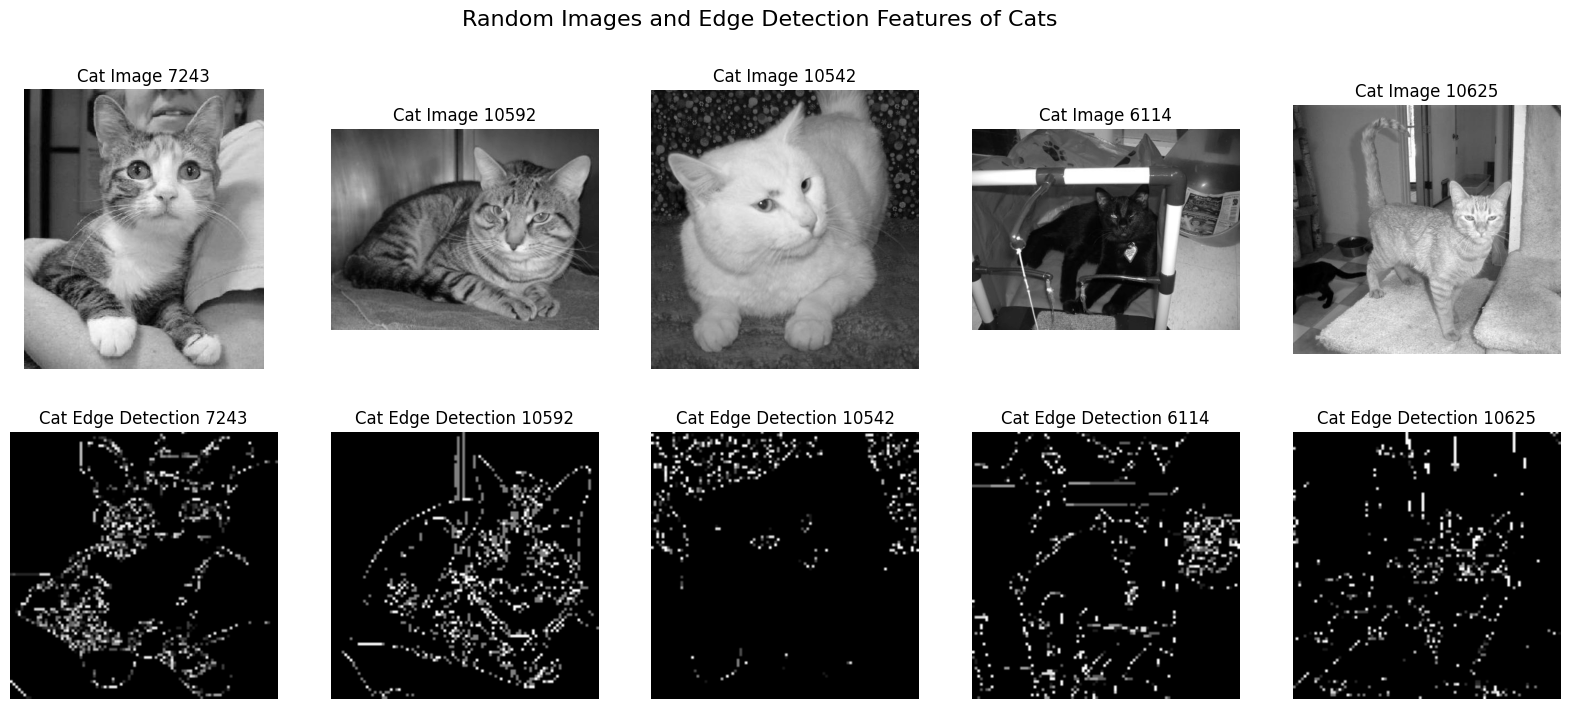

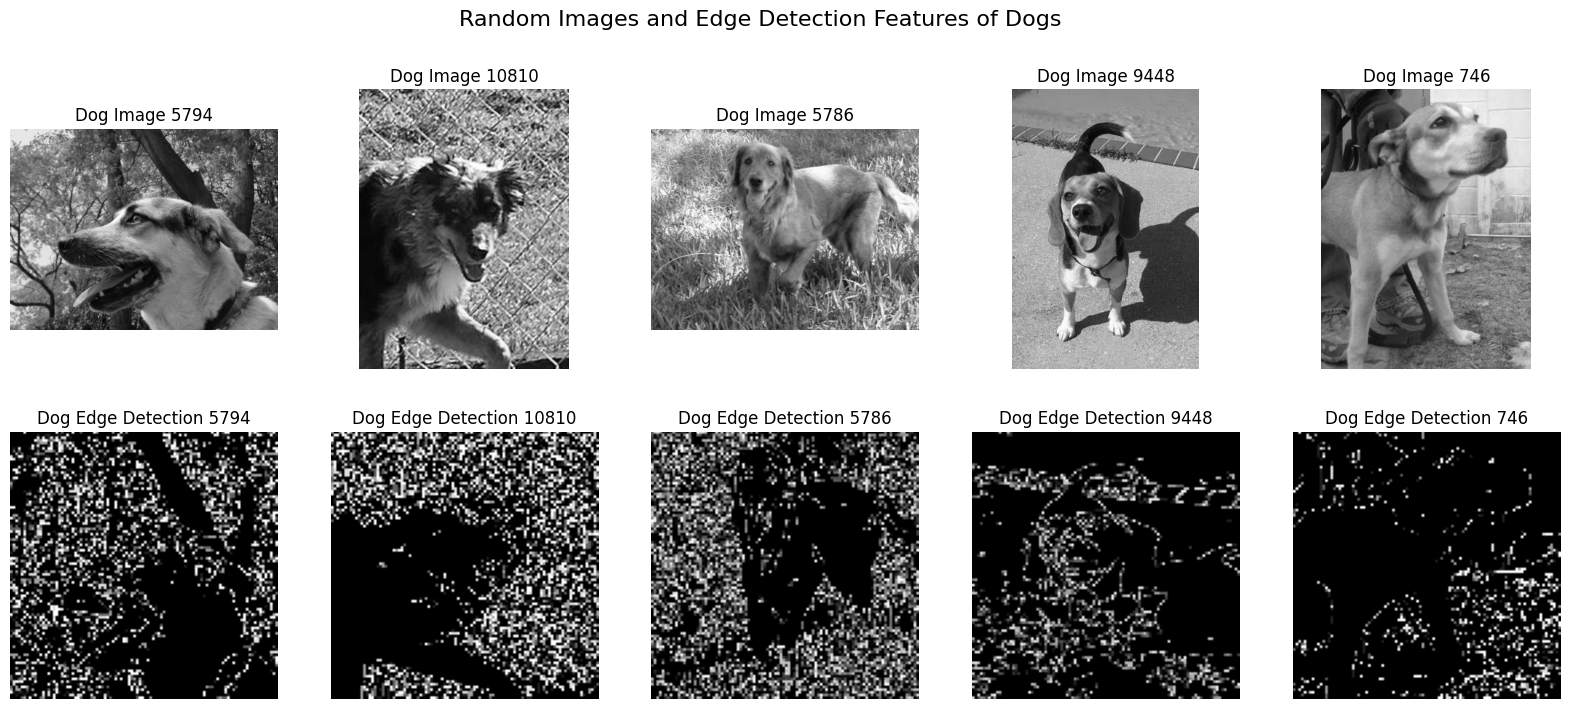

In [8]:
import random
from matplotlib import pyplot as plt

# Function to plot images with their corresponding edge detection features
def plot_images_with_edges(image_folder, edge_features, label):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle(f"Random Images and Edge Detection Features of {label}s", fontsize=16)
    for i in range(5):
        # Select a random index
        index = random.randint(0, len(edge_features) - 1)
        
        # Load the image
        img = cv2.imread(os.path.join(image_folder, sorted(os.listdir(image_folder))[index]), cv2.IMREAD_GRAYSCALE)
        
        # Plot the image
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f"{label} Image {index+1}")
        axes[0, i].axis('off')
        
        # Plot the edge detection feature
        edge_img = edge_features[index].reshape(common_size)
        axes[1, i].imshow(edge_img, cmap='gray')
        axes[1, i].set_title(f"{label} Edge Detection {index+1}")
        axes[1, i].axis('off')

    plt.show()

# Plot random images with edge detection features for cats
plot_images_with_edges(cat_train_path, cat_edge_features, 'Cat')

# Plot random images with edge detection features for dogs
plot_images_with_edges(dog_train_path, dog_edge_features, 'Dog')


In [11]:
# Load and preprocess test Cat and Dog images
cat_test_path = test_path + '/Cat'
dog_test_path = test_path + '/Dog'

# Extract pixel intensity features for test images
cat_test_pixel_features = []
dog_test_pixel_features = []

for filename in sorted(os.listdir(cat_test_path)):
    img = cv2.imread(os.path.join(cat_test_path, filename), cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img, common_size)  
    cat_test_pixel_features.append(resized_img.flatten())

for filename in sorted(os.listdir(dog_test_path)):
    img = cv2.imread(os.path.join(dog_test_path, filename), cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img, common_size)  
    dog_test_pixel_features.append(resized_img.flatten())

cat_test_pixel_features = np.array(cat_test_pixel_features)
dog_test_pixel_features = np.array(dog_test_pixel_features)

# Extract edge features for test images
cat_test_edge_features = extract_canny_edges(cat_test_path, common_size)
dog_test_edge_features = extract_canny_edges(dog_test_path, common_size)

# Combine test features
cat_test_combined_features = combine_features(cat_test_pixel_features, cat_test_edge_features)
dog_test_combined_features = combine_features(dog_test_pixel_features, dog_test_edge_features)

# Predict labels using trained models
y_pred_pixel_cat = rf_classifier_pixel.predict(cat_test_pixel_features)
y_pred_pixel_dog = rf_classifier_pixel.predict(dog_test_pixel_features)
y_pred_combined_cat = rf_classifier_combined.predict(cat_test_combined_features)
y_pred_combined_dog = rf_classifier_combined.predict(dog_test_combined_features)

# Calculate accuracy for each model on test data
accuracy_pixel_cat = accuracy_score(np.zeros(len(y_pred_pixel_cat)), y_pred_pixel_cat)
accuracy_pixel_dog = accuracy_score(np.ones(len(y_pred_pixel_dog)), y_pred_pixel_dog)
accuracy_combined_cat = accuracy_score(np.zeros(len(y_pred_combined_cat)), y_pred_combined_cat)
accuracy_combined_dog = accuracy_score(np.ones(len(y_pred_combined_dog)), y_pred_combined_dog)

print("Accuracy using pixel intensity features only (Cat):", accuracy_pixel_cat)
print("Accuracy using pixel intensity features only (Dog):", accuracy_pixel_dog)
print("Accuracy using combined features (pixel intensity + edge features) (Cat):", accuracy_combined_cat)
print("Accuracy using combined features (pixel intensity + edge features) (Dog):", accuracy_combined_dog)


Accuracy using pixel intensity features only (Cat): 0.692
Accuracy using pixel intensity features only (Dog): 0.614
Accuracy using combined features (pixel intensity + edge features) (Cat): 0.726
Accuracy using combined features (pixel intensity + edge features) (Dog): 0.65


In [16]:


# Combine predictions and true labels for cats and dogs using pixel intensity features only
y_pred_combined = np.concatenate((y_pred_pixel_cat, y_pred_pixel_dog))
y_true_combined = np.concatenate((np.zeros(len(y_pred_pixel_cat)), np.ones(len(y_pred_pixel_dog))))

# Calculate overall accuracy
accuracy_combined = accuracy_score(y_true_combined, y_pred_combined)

print("Overall Accuracy (using pixel intensity features only):", accuracy_combined)



Overall Accuracy (using pixel intensity features only): 0.653


In [17]:


# Combine predictions and true labels for cats and dogs using combined features
y_pred_combined = np.concatenate((y_pred_combined_cat, y_pred_combined_dog))
y_true_combined = np.concatenate((np.zeros(len(y_pred_combined_cat)), np.ones(len(y_pred_combined_dog))))

# Calculate overall accuracy
accuracy_combined = accuracy_score(y_true_combined, y_pred_combined)

print("Overall Accuracy (using combined features):", accuracy_combined)


Overall Accuracy (using combined features): 0.688


In [35]:
from sklearn.model_selection import GridSearchCV

from sklearn.base import BaseEstimator

class CannyEdgeExtractor(BaseEstimator):
    def __init__(self, low_threshold=100, high_threshold=200):
        self.low_threshold = low_threshold
        self.high_threshold = high_threshold

    def fit(self, X, y=None):
        return self

    def transform(self, image_folder, common_size):
        edge_features = []
        for filename in sorted(os.listdir(image_folder)):
            img = cv2.imread(os.path.join(image_folder, filename), cv2.IMREAD_GRAYSCALE)
            # Apply Canny edge detection
            edges = cv2.Canny(img, self.low_threshold, self.high_threshold)
            # Resize the edge image to a common size
            resized_edges = cv2.resize(edges, common_size)
            # Flatten the resized edge image to a 1D array
            edge_features.append(resized_edges.flatten())
        return np.array(edge_features)
    
    def predict(self, X):
        # Dummy predict method that returns zeros
        return np.zeros(len(X))

# Instantiate the CannyEdgeExtractor
canny_edge_extractor = CannyEdgeExtractor()



# Define the parameter grid for grid search
param_grid = {
    'low_threshold': [50, 100, 150],
    'high_threshold': [100, 150, 200]
}

# Use the extractor in the GridSearchCV
grid_search = GridSearchCV(estimator=canny_edge_extractor, param_grid=param_grid, cv=5, scoring='accuracy')

# Train and evaluate Random Forest classifiers using pixel intensity features only
rf_classifier_pixel = train_rf_classifier(np.concatenate((cat_pixel_features, dog_pixel_features)), labels)

# Predict labels using trained model
y_pred_pixel_cat = rf_classifier_pixel.predict(cat_pixel_features)
y_pred_pixel_dog = rf_classifier_pixel.predict(dog_pixel_features)

# Combine predictions and true labels for cats and dogs using pixel intensity features only
y_pred_combined = np.concatenate((y_pred_pixel_cat, y_pred_pixel_dog))
y_true_combined = np.concatenate((np.zeros(len(y_pred_pixel_cat)), np.ones(len(y_pred_pixel_dog))))

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (Accuracy Combined):", best_score)




Best Parameters: {'high_threshold': 100, 'low_threshold': 50}
Best Score (Accuracy Combined): 0.4994995450409463
